## Running Corncob to look for differential abundances

In [1]:
library(phyloseq)
library(wesanderson)
library(ggplot2)
library(vegan)
library(dplyr)
library(corncob)

Loading required package: permute
Loading required package: lattice
This is vegan 2.5-6

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
ps=readRDS("../data/CornellITS2/ps.ITS2")
ps.norm=readRDS("../data/CornellITS2/ps.ITS2.norm")
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1810 taxa and 177 samples ]
sample_data() Sample Data:       [ 177 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 1810 taxa by 7 taxonomic ranks ]

In [3]:
# Most interested in the final timepoint, for OM and for PyOM

#Factors = expand.grid(Soil_Trtmt=c("Hawaii","Alaska","Utah","New York","Florida"),Day=c("10","26"),Amdmt=c("OM","PyOM"))
Factors = expand.grid(Soil_Trtmt=c("Hawaii","Alaska","Utah","New York","Florida"),Amdmt=c("OM","PyOM"))
Factors

Soil_Trtmt,Amdmt
<fct>,<fct>
Hawaii,OM
Alaska,OM
Utah,OM
New York,OM
Florida,OM
Hawaii,PyOM
Alaska,PyOM
Utah,PyOM
New York,PyOM


In [6]:
# This should take all the OTUs from each soil, and find their average abundance (across all samples in that soil)
# Then, for each OTU, we look across the soils and see what the average average abundance is, plus the max and min
# That allows us to include abundant taxa
# Ok, but previously we were calculating the abundant taxa within just a single soil anyway
# So, I guess this is not necessary...
# But could reduce cutoff futher to be sure to include all possible taxa...
AbundTaxa = psmelt(ps.norm)%>%
    group_by(Soil_Trtmt,OTU)%>%
    summarize(MeanAbund=mean(Abundance))%>%
    group_by(OTU)%>%
    summarize(OverallMeanAbund=mean(MeanAbund),MaxAbund=max(MeanAbund),MinAbund=min(MeanAbund))%>%
    arrange(-OverallMeanAbund)
head(AbundTaxa)

OTU,OverallMeanAbund,MaxAbund,MinAbund
<chr>,<dbl>,<dbl>,<dbl>
OTU2,0.06124741,0.1942210,8.071010e-04
OTU1,0.05058680,0.2482875,5.827245e-05
OTU3,0.04552510,0.1382869,0.000000e+00
OTU10,0.04206690,0.2103345,0.000000e+00
OTU8,0.03313128,0.1636249,0.000000e+00
OTU4,0.02939538,0.1468503,0.000000e+00


In [12]:
# Make function to test for differential abundance
# controlling for differential variance
da_analysis = function(Factors){
    Soil_Trtmt=paste(Factors["Soil_Trtmt"])
    Amdmt=paste(Factors["Amdmt"])
    ps.DA = prune_samples(sample_data(ps)$Soil_Trtmt==Soil_Trtmt & sample_data(ps)$Day %in% c("10","26") & (sample_data(ps)$Amdmt == Amdmt | sample_data(ps)$Amdmt == "Soil"),ps)
    ps.DA = prune_taxa(taxa_sums(ps.DA)>0,ps.DA)
    print(ps.DA)
    AbundTaxa = taxa_names(filter_taxa(ps.norm, function(x) mean(x) > 0.0001, TRUE))
    ps.DA = prune_taxa(AbundTaxa,ps.DA)
    print(ps.DA)
    dT = differentialTest(formula = ~ Day+Amdmt,
    phi.formula = ~ Day+Amdmt,
    formula_null = ~ Day,
    phi.formula_null = ~ Day+Amdmt,
    test = "Wald", boot = FALSE,
    data = ps.DA,
    fdr_cutoff = 0.05)
    results=list(dT,Amdmt,Soil_Trtmt)
    return(results)
    }

In [13]:
results = apply(Factors[c(1:10),],1,da_analysis)
# This produces a series of items with the corncob results for each soil/amendment combination

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 161 taxa and 16 samples ]
sample_data() Sample Data:       [ 16 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 161 taxa by 7 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 61 taxa and 16 samples ]
sample_data() Sample Data:       [ 16 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 61 taxa by 7 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 118 taxa and 16 samples ]
sample_data() Sample Data:       [ 16 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 118 taxa by 7 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 64 taxa and 16 samples ]
sample_data() Sample Data:       [ 16 samples by 69 sample variables ]
tax_table()   Taxonomy Table:    [ 64 taxa by 7 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()  

In [14]:
#saveRDS(results,"../data/CornellITS2/DA.results.ITS2")
#saveRDS(results,"../data/CornellITS2/DA.results.ITS2.0.001")
#saveRDS(results,"../data/CornellITS2/DA.results.ITS2.0.0001")

In [15]:
cutoff=0.05
r = lapply(results, function(l) l[[1]])
sigOTUs = c(
row.names(tax_table(r[[1]]$data)[!is.na(r[[1]]$p_fdr) & r[[1]]$p_fdr<cutoff]),
#row.names(tax_table(r[[2]]$data)[!is.na(r[[2]]$p_fdr) & r[[2]]$p_fdr<cutoff]),
row.names(tax_table(r[[3]]$data)[!is.na(r[[3]]$p_fdr) & r[[3]]$p_fdr<cutoff]),
row.names(tax_table(r[[4]]$data)[!is.na(r[[4]]$p_fdr) & r[[4]]$p_fdr<cutoff]),
row.names(tax_table(r[[5]]$data)[!is.na(r[[5]]$p_fdr) & r[[5]]$p_fdr<cutoff]),
#row.names(tax_table(r[[6]]$data)[!is.na(r[[6]]$p_fdr) & r[[6]]$p_fdr<cutoff]), # No significant taxa
#row.names(tax_table(r[[7]]$data)[!is.na(r[[7]]$p_fdr) & r[[7]]$p_fdr<cutoff]),
#row.names(tax_table(r[[8]]$data)[!is.na(r[[8]]$p_fdr) & r[[8]]$p_fdr<cutoff]),
row.names(tax_table(r[[9]]$data)[!is.na(r[[9]]$p_fdr) & r[[9]]$p_fdr<cutoff]),
row.names(tax_table(r[[10]]$data)[!is.na(r[[10]]$p_fdr) & r[[10]]$p_fdr<cutoff]))
levels(as.factor(sigOTUs))

[1] "OTU1"   "OTU10"  "OTU105" "OTU20"  "OTU4"   "OTU576" "OTU98"

In [16]:
# For each list, and for each significant taxon in that list, extract the mu coefficients and the p_fdr
# Currently not running for 2,6,7, and 8 because no significant taxa

df = data.frame()
for (i in c(1,3,4,5,9,10)){
    r = results[[i]][[1]]
    Amdmt = try(results[[i]][[2]])
    Soil = try(results[[i]][[3]])
    for (j in 1:length(r$significant_taxa)){
        sig_models = try(r$significant_models[[j]],silent=TRUE)
        mu = try(data.frame(t(as.matrix(sig_models$coefficients[3,]))),silent=TRUE)
        p_fdr = try(r$p_fdr[r$significant_taxa][j],silent=TRUE)
        mu$p_fdr = try(p_fdr,silent=TRUE)
        mu$Amdmt = try(Amdmt,silent=TRUE)
        mu$Soil = try(Soil,silent=TRUE)
        row.names(mu)= try(paste(row.names(try(data.frame(p_fdr))),"_",i,sep=""),silent=TRUE)
        df = try(rbind(df,mu))
    }
}

In [17]:
df$OTU = row.names(df)
colnames(df) = c("log2FC","se","t","p","p_fdr","Amdmt","Soil_Trtmt","OTU")
dim(df)
head(df)
# Final summary of results - actually I think this is all we want.

[1] 7 8

,log2FC,se,t,p,p_fdr,Amdmt,Soil_Trtmt,OTU
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
OTU1_1,-2.703783,0.8330667,-3.245578,8.786032e-03,1.758189e-02,OM,Hawaii,OTU1_1
OTU4_3,-3.200196,0.3004376,-10.651784,8.885044e-07,1.539495e-25,OM,Utah,OTU4_3
OTU10_4,-4.228979,1.2382561,-3.415270,6.599622e-03,7.646252e-03,OM,New York,OTU10_4
OTU20_5,-7.136893,1.9128196,-3.731085,3.903379e-03,1.715912e-03,OM,Florida,OTU20_5
OTU98_9,-8.072926,0.7217836,-11.184691,5.645628e-07,1.647604e-27,PyOM,New York,OTU98_9
OTU576_9,4.443103,1.3989090,3.176120,9.884364e-03,2.537406e-02,PyOM,New York,OTU576_9


In [18]:
df$OTU = row.names(df)
df$OTU = sub("_[0-9]","",df$OTU)
df$OTU

[1] "OTU1"    "OTU4"    "OTU10"   "OTU20"   "OTU98"   "OTU576"  "OTU1050"

In [19]:
SigOTUs = levels(as.factor(df$OTU))
pruned = prune_taxa(SigOTUs,ps.norm)
taxtab = data.frame(tax_table(pruned))
taxtab$OTU = c(taxa_names(pruned))
joined = merge(taxtab,df,by=c("OTU"))
#head(joined)

In [20]:
ignoreList = c("","uncultured","uncultured bacterium","uncultured soil bacterium","uncultured forest soil bacterium","uncultured actinobacterium","uncultured planctomycete")

joined$Phylum = ifelse(joined$Phylum=="WPS-2","Eremiobacterota (WPS-2)",paste(joined$Phylum))

joined = joined %>%
    mutate(Name = ifelse(Genus %in% ignoreList |is.na(Genus),ifelse(Family %in% ignoreList |is.na(Family),ifelse(Class %in% ignoreList |is.na(Class),ifelse(Phylum %in% ignoreList |is.na(Phylum),paste(OTU),
                            paste(Phylum)),paste(Class)),paste(Family)),paste(Genus)))#%>%
    #mutate(Name = paste(Name,"\n(OTU",OTU,")"),sep="")
head(joined$Name)

[1] "Saitozyma"     "Fusarium"      "Tulostoma"     "Umbelopsis"   
[5] "Alternaria"    "Spizellomyces"

In [21]:
head(joined)

OTU,Kingdom,Phylum,Class,Order,Family,Genus,Species,log2FC,se,t,p,p_fdr,Amdmt,Soil_Trtmt,Name
<chr>,<fct>,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
OTU1,Fungi,Basidiomycota,Tremellomycetes,Tremellales,Trimorphomycetaceae,Saitozyma,podzolica,-2.703783,0.8330667,-3.245578,8.786032e-03,1.758189e-02,OM,Hawaii,Saitozyma
OTU10,Fungi,Ascomycota,Sordariomycetes,Hypocreales,Nectriaceae,Fusarium,oxysporum,-4.228979,1.2382561,-3.415270,6.599622e-03,7.646252e-03,OM,New York,Fusarium
OTU1050,Fungi,Basidiomycota,Agaricomycetes,Agaricales,Agaricaceae,Tulostoma,kotlabae,-6.520177,2.0058201,-3.250629,8.711207e-03,2.533298e-02,PyOM,Florida,Tulostoma
OTU20,Fungi,Mucoromycota,Umbelopsidomycetes,Umbelopsidales,Umbelopsidaceae,Umbelopsis,dimorpha,-7.136893,1.9128196,-3.731085,3.903379e-03,1.715912e-03,OM,Florida,Umbelopsis
OTU4,Fungi,Ascomycota,Dothideomycetes,Pleosporales,Pleosporaceae,Alternaria,chlamydosporigena,-3.200196,0.3004376,-10.651784,8.885044e-07,1.539495e-25,OM,Utah,Alternaria
OTU576,Fungi,Chytridiomycota,Spizellomycetes,Spizellomycetales,Spizellomycetaceae,Spizellomyces,NA,4.443103,1.3989090,3.176120,9.884364e-03,2.537406e-02,PyOM,New York,Spizellomyces


In [22]:
TaxonOrder = joined %>%
    select(Phylum,Genus,OTU,Name)%>%
    arrange(Phylum)
OTUOrder = unique(TaxonOrder$OTU)
GenusOrder = unique(TaxonOrder$Genus)
NameOrder = unique(TaxonOrder$Name)
joined$OTU = factor(joined$OTU, levels = OTUOrder)
joined$Genus = factor(joined$Genus, levels = GenusOrder)
joined$Name = factor(joined$Name, levels = NameOrder)
joined$Soil_Trtmt = factor(joined$Soil_Trtmt, levels = c("Hawaii","Alaska","Utah","New York","Florida"))

levels(joined$Soil_Trtmt)[levels(joined$Soil_Trtmt)=="Hawaii"] = "Hydrudand"
levels(joined$Soil_Trtmt)[levels(joined$Soil_Trtmt)=="New York"] = "Fragiudept"
levels(joined$Soil_Trtmt)[levels(joined$Soil_Trtmt)=="Alaska"] = "Cryaquept"
levels(joined$Soil_Trtmt)[levels(joined$Soil_Trtmt)=="Utah"] = "Haplocalcid"
levels(joined$Soil_Trtmt)[levels(joined$Soil_Trtmt)=="Florida"] = "Quartzipsamment"

joined.plot = joined %>%
    filter(log2FC>0)

joined.plot2 = joined %>%
    filter(log2FC<0)

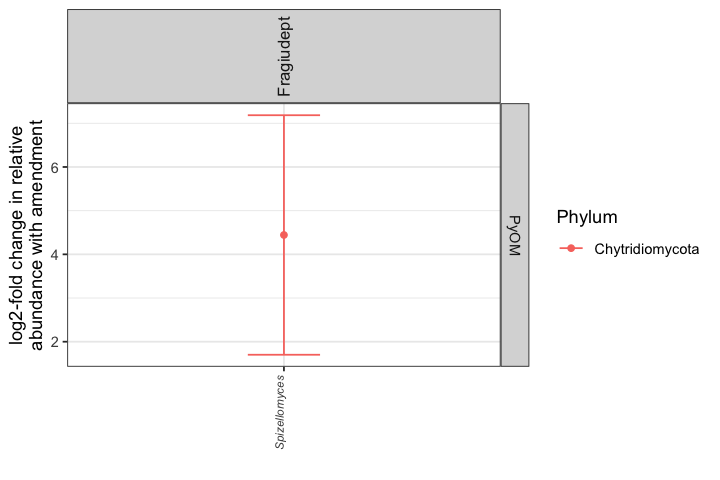

In [26]:
options(repr.plot.width=6, repr.plot.height=4)

#palette=brewer.pal(9,"Set1")

p = ggplot(joined.plot,aes(y=log2FC,color=Phylum,x=Name))
p = p + theme_bw()
p = p + geom_point() + facet_grid(~Amdmt~Soil_Trtmt,scales="free_x",space="free_x")
p = p + geom_errorbar(aes(ymax=log2FC+1.96*se,ymin=log2FC-1.96*se),width=0.2)
p = p + theme(axis.text.x=element_text(angle=90,size=7,face="italic",vjust=0,hjust=1))
p = p + theme(strip.text.x=element_text(angle=90,size=10))
p = p + ylab("log2-fold change in relative\nabundance with amendment") + xlab("")
#p = p + scale_color_manual(values=palette)
p

# This might be about what we want - the last question would be a relative abundance - sized by that
# Could size by baseline relative abundance.
# Also need to decide on how/whether to readjust p-values across soils
# Overall, pretty good, though - conclusion - some taxa are consistent reponders

## Old stuff

In [7]:
# For each list, and for each significant taxon in that list, extract the mu coefficients and the p_fdr
# Currently not runnign for 6, because no significant taxa

df = data.frame()
#for (i in c(1:3,6:7)){
for (i in c(1:10)){
    r = results[[i]][[1]]
    Amdmt = try(results[[i]][[2]])
    Soil = try(results[[i]][[3]])
    for (j in 1:length(r$significant_taxa)){
        sig_models = try(r$significant_models[[j]],silent=TRUE)
        mu = try(data.frame(t(as.matrix(sig_models$coefficients[3,]))),silent=TRUE)
        p_fdr = try(r$p_fdr[r$significant_taxa][j],silent=TRUE)
        mu$p_fdr = try(p_fdr,silent=TRUE)
        mu$Amdmt = try(Amdmt,silent=TRUE)
        mu$Soil = try(Soil,silent=TRUE)
        row.names(mu)= try(row.names(try(data.frame(p_fdr))),silent=TRUE)
        df = try(rbind(df,mu))
    }
}

Warning message in mu$p_fdr <- try(p_fdr, silent = TRUE):
“Coercing LHS to a list”

Error in data.frame(p_fdr) : row names contain missing values
Error in rbind(deparse.level, ...) : 
  numbers of columns of arguments do not match


Warning message in mu$p_fdr <- try(p_fdr, silent = TRUE):
“Coercing LHS to a list”

ERROR: Error in `rownames<-`(x, value): attempt to set 'rownames' on an object with no dimensions


In [13]:
df$OTU = row.names(df)
colnames(df) = c("log2FC","se","t","p","p_fdr","Amdmt","Soil_Trtmt","OTU")
head(df)
# Final summary of results

,log2FC,se,t,p,p_fdr,Amdmt,Soil_Trtmt,OTU
OTU1,-2.753606,0.8320948,-3.309245,7.889371e-03,1.029027e-02,OM,Hawaii,OTU1
OTU10,-4.317613,1.2637593,-3.416484,6.586187e-03,6.343539e-03,OM,New York,OTU10
OTU20,-7.081772,1.9380804,-3.654014,4.432763e-03,1.807208e-03,OM,Florida,OTU20
OTU98,-7.907238,0.7199981,-10.982304,6.691748e-07,1.022812e-26,PyOM,New York,OTU98
OTU105,-6.542371,1.9764818,-3.310109,7.877870e-03,1.305634e-02,PyOM,Florida,OTU105


In [14]:
SigOTUs = row.names(df)
pruned = prune_taxa(SigOTUs,ps.norm)
taxtab = data.frame(tax_table(pruned))
taxtab$OTU = c(taxa_names(pruned))
joined = merge(taxtab,df,by=c("OTU"))
head(joined)

OTU,Kingdom,Phylum,Class,Order,Family,Genus,Species,log2FC,se,t,p,p_fdr,Amdmt,Soil_Trtmt
OTU1,Fungi,Basidiomycota,Tremellomycetes,Tremellales,Trimorphomycetaceae,Saitozyma,podzolica,-2.753606,0.8320948,-3.309245,7.889371e-03,1.029027e-02,OM,Hawaii
OTU10,Fungi,Ascomycota,Sordariomycetes,Hypocreales,Nectriaceae,Fusarium,oxysporum,-4.317613,1.2637593,-3.416484,6.586187e-03,6.343539e-03,OM,New York
OTU105,Fungi,Chytridiomycota,Spizellomycetes,Spizellomycetales,Spizellomycetaceae,Spizellomyces,NA,-6.542371,1.9764818,-3.310109,7.877870e-03,1.305634e-02,PyOM,Florida
OTU20,Fungi,Mucoromycota,Umbelopsidomycetes,Umbelopsidales,Umbelopsidaceae,Umbelopsis,dimorpha,-7.081772,1.9380804,-3.654014,4.432763e-03,1.807208e-03,OM,Florida
OTU98,Fungi,Ascomycota,Sordariomycetes,Glomerellales,Plectosphaerellaceae,Gibellulopsis,piscis,-7.907238,0.7199981,-10.982304,6.691748e-07,1.022812e-26,PyOM,New York


In [16]:
ignoreList = c("","uncultured")

joined = joined %>%
    mutate(Name = ifelse(Genus %in% ignoreList |is.na(Genus),ifelse(Family %in% ignoreList |is.na(Family),ifelse(Class %in% ignoreList |is.na(Class),ifelse(Phylum %in% ignoreList |is.na(Phylum),paste(OTU),
                            paste(Phylum)),paste(Class)),paste(Family)),paste(Genus)))#%>%
    #mutate(Name = paste(Name,"\n(OTU",OTU,")"),sep="")
head(joined$Name)

[1] "Saitozyma"     "Fusarium"      "Spizellomyces" "Umbelopsis"   
[5] "Gibellulopsis"

In [17]:
TaxonOrder = joined %>%
    select(Phylum,Genus,OTU,Name)%>%
    arrange(Phylum)
OTUOrder = unique(TaxonOrder$OTU)
GenusOrder = unique(TaxonOrder$Genus)
NameOrder = unique(TaxonOrder$Name)
joined$OTU = factor(joined$OTU, levels = OTUOrder)
joined$Genus = factor(joined$Genus, levels = GenusOrder)
joined$Name = factor(joined$Name, levels = NameOrder)
joined$Soil_Trtmt = factor(joined$Soil_Trtmt, levels = c("Hawaii","Alaska","Utah","New York","Florida"))

levels(joined$Soil_Trtmt)[levels(joined$Soil_Trtmt)=="Hawaii"] = "Hydrudand"
levels(joined$Soil_Trtmt)[levels(joined$Soil_Trtmt)=="New York"] = "Fragiudept"
levels(joined$Soil_Trtmt)[levels(joined$Soil_Trtmt)=="Alaska"] = "Cryaquept"
levels(joined$Soil_Trtmt)[levels(joined$Soil_Trtmt)=="Utah"] = "Haplocalcid"
levels(joined$Soil_Trtmt)[levels(joined$Soil_Trtmt)=="Florida"] = "Quartzipsamment"

joined.plot = joined %>%
    filter(log2FC>0)

In [23]:
head(joined.plot$Name)

factor(0)
Levels: Fusarium Gibellulopsis Saitozyma Spizellomyces Umbelopsis

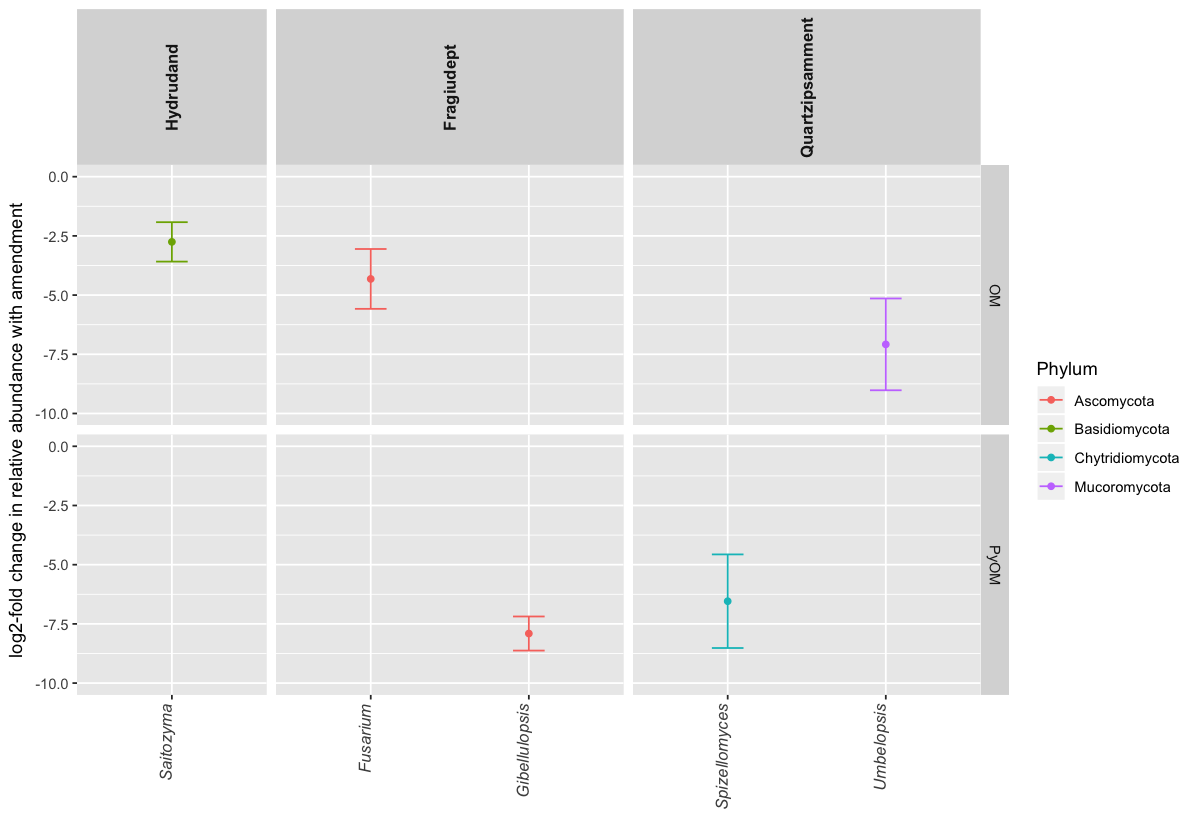

In [32]:
options(repr.plot.width=10, repr.plot.height=7)
p = ggplot(joined,aes(y=log2FC,color=Phylum,x=Name))
p = p + geom_point() + facet_grid(~Amdmt~Soil_Trtmt,scales="free_x",space="free_x")
p = p + geom_errorbar(aes(ymax=log2FC+se,ymin=log2FC-se),width=0.2)
p = p + theme(axis.text.x=element_text(angle=90,size=10,face="italic",vjust=0,hjust=1))
p = p + theme(strip.text.x=element_text(angle=90,size=10,face="bold"))
p = p + ylab("log2-fold change in relative abundance with amendment") + xlab("")
p = p + ylim(values=c(-10,0))
p
# This might be about what we want - the last question would be a relative abundance - sized by that
# Could size by baseline relative abundance.
# Also need to decide on how/whether to readjust p-values across soils
# Overall, pretty good, though - conclusion - some taxa are consistent reponders

In [113]:
# Want to make analogous figures to ISME paper
# So, need to match up OTUs across days
# Goal: OTU taxonomy, Soil, Day, Response to PyOM, Response to OM

d.cast.l2FC = cast(df, Soil_Trtmt+OTU~Amdmt,value=c("log2FC"))
d.cast.SE = cast(df, Soil_Trtmt+OTU~Amdmt,value=c("se"))
d.cast.padj = cast(df, Soil_Trtmt+OTU~Amdmt,value=c("p_fdr"))

d.cast = merge(d.cast.l2FC,d.cast.SE,by=c("Soil_Trtmt","OTU"))
d.cast = merge(d.cast,d.cast.padj,by=c("Soil_Trtmt","OTU"))

colnames(d.cast) = c(colnames(d.cast)[1:2],"logFC.OM","logFC.PyOM","logFC.SE.OM","logFC.SE.PyOM","logFC.padj.OM","logFC.padj.PyOM")
head(d.cast)

Soil_Trtmt,OTU,logFC.OM,logFC.PyOM,logFC.SE.OM,logFC.SE.PyOM,logFC.padj.OM,logFC.padj.PyOM
Florida,OTU105,NA,-6.542371,NA,1.9764818,NA,1.305634e-02
Florida,OTU20,-7.081772,NA,1.9380804,NA,0.001807208,NA
Hawaii,OTU1,-2.753606,NA,0.8320948,NA,0.010290269,NA
New York,OTU10,-4.317613,NA,1.2637593,NA,0.006343539,NA
New York,OTU98,NA,-7.907238,NA,0.7199981,NA,1.022820e-26


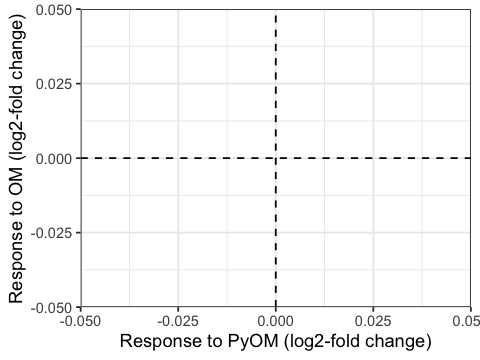

In [117]:
options(repr.plot.width=4, repr.plot.height=3)
d.plot = d.cast%>%
    filter(!is.na(logFC.padj.PyOM) & !is.na(logFC.padj.OM))

d.plot$Soil_Name=d.plot$Soil_Trtmt

d.plot$Soil_Name = ordered(d.plot$Soil_Name, levels = c("Hydrudand", "Cryaquept", "Haplocalcid","Fragiudept","Quartzipsamment"))

p = ggplot(d.plot,aes(x=logFC.PyOM,y=logFC.OM,shape=Soil_Trtmt,color=Soil_Trtmt,fill=Soil_Trtmt))
p = p + geom_point(size=3,alpha=0.7)
p = p + geom_hline(yintercept = 0.0, linetype=2) + theme_bw()
p = p + geom_vline(xintercept = 0.0, linetype=2) + theme_bw()
p = p + xlab("Response to PyOM (log2-fold change)")
p = p + ylab("Response to OM (log2-fold change)")

palette = c(wes_palette("Darjeeling1"),wes_palette("Darjeeling2")[2:4])
palette = palette[c(2,1,4,3,5,6)]
p = p + scale_fill_manual(values=palette)+ scale_color_manual(values=palette) + scale_shape_manual(values=c(21:25))
p = p + guides(shape = guide_legend(title="Soil Type"), color=guide_legend(title="Soil Type"), fill=guide_legend(title="Soil Type"))
p
# No seqs in common in a given soil for OM and PyOM

In [74]:
cutoff=0.05
tax_table(results[[1]]$data)[!is.na(results[[1]]$p_fdr) & results[[1]]$p_fdr<cutoff]
tax_table(results[[2]]$data)[!is.na(results[[2]]$p_fdr) & results[[2]]$p_fdr<cutoff]
tax_table(results[[3]]$data)[!is.na(results[[3]]$p_fdr) & results[[3]]$p_fdr<cutoff]
tax_table(results[[4]]$data)[!is.na(results[[4]]$p_fdr) & results[[4]]$p_fdr<cutoff]

,Kingdom,Phylum,Class,Order,Family,Genus,Species
OTU1,Fungi,Basidiomycota,Tremellomycetes,Tremellales,Trimorphomycetaceae,Saitozyma,podzolica


,Kingdom,Phylum,Class,Order,Family,Genus,Species
OTU4,Fungi,Ascomycota,Dothideomycetes,Pleosporales,Pleosporaceae,Alternaria,chlamydosporigena


,Kingdom,Phylum,Class,Order,Family,Genus,Species
OTU10,Fungi,Ascomycota,Sordariomycetes,Hypocreales,Nectriaceae,Fusarium,oxysporum
OTU102,Fungi,Chytridiomycota,Spizellomycetes,Spizellomycetales,Spizellomycetaceae,Spizellomyces,dolichospermus


,Kingdom,Phylum,Class,Order,Family,Genus,Species
OTU20,Fungi,Mucoromycota,Umbelopsidomycetes,Umbelopsidales,Umbelopsidaceae,Umbelopsis,dimorpha
OTU142,Fungi,Mucoromycota,Mucoromycetes,Mucorales,Rhizopodaceae,Rhizopus,microsporus


In [109]:
results[[1]]$significant_taxa
results[[1]]$significant_models[1]
results[[2]]$significant_taxa
results[[2]]$significant_models[2]
results[[3]]$significant_taxa
results[[3]]$significant_models[1]
results[[3]]$significant_models[7]
results[[4]]$significant_taxa
results[[4]]$significant_models[2]
results[[4]]$significant_models[9]

[1] "OTU1"   "OTU6"   "OTU8"   "OTU11"  "OTU21"  "OTU34"  "OTU42"  "OTU57" 
 [9] "OTU60"  "OTU67"  "OTU79"  "OTU81"  "OTU106" "OTU114" "OTU123" "OTU197"
[17] "OTU207" "OTU235" "OTU337" "OTU439" "OTU459" "OTU503"

[[1]]

Call:
bbdml(formula = formula_i, phi.formula = phi.formula, data = data_i, 
    link = link, phi.link = phi.link, inits = inits)


Coefficients associated with abundance:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  -0.7348     0.4186  -1.755  0.10466   
AmdmtOM      -2.6954     0.8348  -3.229  0.00724 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Coefficients associated with dispersion:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  -0.6776     0.4412  -1.536    0.151
AmdmtOM      -1.2412     0.9329  -1.331    0.208


Log-likelihood: -139.31


[1] "OTU2"   "OTU4"   "OTU13"  "OTU18"  "OTU26"  "OTU29"  "OTU38"  "OTU44" 
 [9] "OTU45"  "OTU282" "OTU297" "OTU339"

[[1]]

Call:
bbdml(formula = formula_i, phi.formula = phi.formula, data = data_i, 
    link = link, phi.link = phi.link, inits = inits)


Coefficients associated with abundance:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -1.4282     0.1950  -7.326 9.15e-06 ***
AmdmtOM      -3.2084     0.2845 -11.278 9.62e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Coefficients associated with dispersion:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -2.9990     0.4948  -6.061 5.66e-05 ***
AmdmtOM      -2.7316     0.7178  -3.805  0.00251 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Log-likelihood: -127.88


[1] "OTU10"  "OTU12"  "OTU27"  "OTU50"  "OTU69"  "OTU75"  "OTU102" "OTU127"
 [9] "OTU151" "OTU163" "OTU303" "OTU358"

[[1]]

Call:
bbdml(formula = formula_i, phi.formula = phi.formula, data = data_i, 
    link = link, phi.link = phi.link, inits = inits)


Coefficients associated with abundance:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -1.3140     0.1068 -12.308 3.64e-08 ***
AmdmtOM      -4.3645     1.2793  -3.412  0.00516 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Coefficients associated with dispersion:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -4.1748     0.4999  -8.351 2.42e-06 ***
AmdmtOM       1.0998     1.5020   0.732    0.478    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Log-likelihood: -90.954


[[1]]

Call:
bbdml(formula = formula_i, phi.formula = phi.formula, data = data_i, 
    link = link, phi.link = phi.link, inits = inits)


Coefficients associated with abundance:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -3.7584     0.6521  -5.764 8.97e-05 ***
AmdmtOM      -5.8078     2.0596  -2.820   0.0155 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Coefficients associated with dispersion:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  -2.4988     0.7868  -3.176  0.00798 **
AmdmtOM      -3.6655     2.4063  -1.523  0.15360   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Log-likelihood: -56.71


[1] "OTU17"   "OTU20"   "OTU25"   "OTU28"   "OTU33"   "OTU35"   "OTU61"  
 [8] "OTU128"  "OTU142"  "OTU143"  "OTU195"  "OTU319"  "OTU720"  "OTU1283"

[[1]]

Call:
bbdml(formula = formula_i, phi.formula = phi.formula, data = data_i, 
    link = link, phi.link = phi.link, inits = inits)


Coefficients associated with abundance:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -2.5563     0.3815  -6.700  2.2e-05 ***
AmdmtOM      -6.7825     2.0446  -3.317  0.00614 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Coefficients associated with dispersion:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -2.4688     0.5466  -4.517 0.000706 ***
AmdmtOM      -3.4060     2.3784  -1.432 0.177656    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Log-likelihood: -76.103


[[1]]

Call:
bbdml(formula = formula_i, phi.formula = phi.formula, data = data_i, 
    link = link, phi.link = phi.link, inits = inits)


Coefficients associated with abundance:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -9.861      1.794  -5.497 0.000137 ***
AmdmtOM        5.952      2.194   2.712 0.018875 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Coefficients associated with dispersion:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)   -6.629      2.144  -3.091  0.00934 **
AmdmtOM        5.563      2.531   2.197  0.04836 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Log-likelihood: -40.634


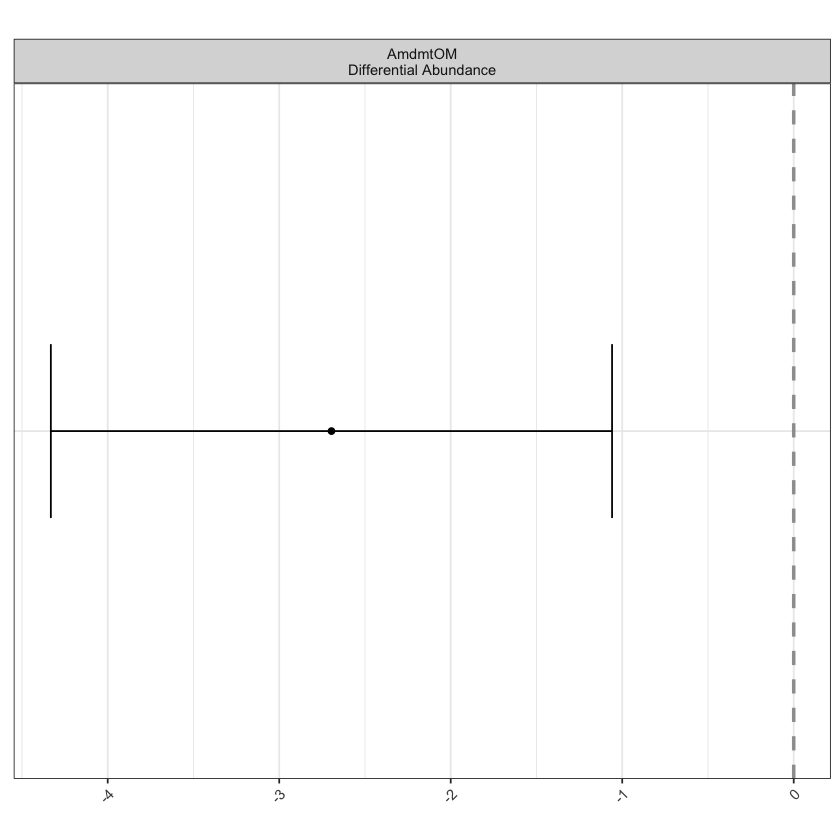

In [61]:
p = plot(results[[1]])
p = p + theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())
p

In [121]:
SigOTUs = c("OTU1","OTU4","OTU10","OTU102","OTU20","OTU142")

In [131]:
ps.sig = prune_taxa(taxa_names(ps.norm) %in% SigOTUs,ps.norm)
mdf = psmelt(ps.sig)
mdf = mdf %>%
    filter(Day=="26")%>%
    group_by(Soil_Trtmt,OTU,Genus,Amdmt)%>%
    #summarize(meanAbund=mean(Abundance))%>%
    arrange(OTU)
mdf

OTU,Sample,Abundance,Tube_ID,Seq_ID,Proj_ID,Soil_Rep_Day,Soil_Rep_Day_Trtmt,Qorpak_ID,Amdmt_mg,⋯,Soil.CO2.mean.mg.per.gram.soil.C.cum,Amdmt.CO2.mean.mg.per.mg.amdmt.C.cum,Soil_Name,Kingdom,Phylum,Class,Order,Family,Genus,Species
OTU1,CNL_066,0.664435910,CNL_66,66,CNL,HI_C_26,HI_C_26_Soil,66,x,⋯,19.96488,NA,Hydrudand,Fungi,Basidiomycota,Tremellomycetes,Tremellales,Trimorphomycetaceae,Saitozyma,podzolica
OTU1,CNL_064,0.582690846,CNL_64,64,CNL,HI_C_26,HI_C_26_PyOM,64,10.95,⋯,32.31951,0.03694358,Hydrudand,Fungi,Basidiomycota,Tremellomycetes,Tremellales,Trimorphomycetaceae,Saitozyma,podzolica
OTU1,CNL_070,0.212720421,CNL_70,70,CNL,HI_D_26,HI_D_26_PyOM,70,11.07,⋯,30.81563,0.02706653,Hydrudand,Fungi,Basidiomycota,Tremellomycetes,Tremellales,Trimorphomycetaceae,Saitozyma,podzolica
OTU1,CNL_072,0.173859935,CNL_72,72,CNL,HI_D_26,HI_D_26_Soil,72,x,⋯,29.81276,NA,Hydrudand,Fungi,Basidiomycota,Tremellomycetes,Tremellales,Trimorphomycetaceae,Saitozyma,podzolica
OTU1,CNL_062,0.096182760,CNL_62,62,CNL,HI_C_26,HI_C_26_OM,62,30.05,⋯,32.17582,0.49867837,Hydrudand,Fungi,Basidiomycota,Tremellomycetes,Tremellales,Trimorphomycetaceae,Saitozyma,podzolica
OTU1,CNL_058,0.071571409,CNL_58,58,CNL,HI_B_26,HI_B_26_PyOM,58,10.95,⋯,17.37512,0.02451997,Hydrudand,Fungi,Basidiomycota,Tremellomycetes,Tremellales,Trimorphomycetaceae,Saitozyma,podzolica
OTU1,CNL_060,0.032534209,CNL_60,60,CNL,HI_B_26,HI_B_26_Soil,60,x,⋯,25.49399,NA,Hydrudand,Fungi,Basidiomycota,Tremellomycetes,Tremellales,Trimorphomycetaceae,Saitozyma,podzolica
OTU1,CNL_054,0.022574097,CNL_54,54,CNL,HI_A_26,HI_A_26_Soil,54,x,⋯,41.17556,NA,Hydrudand,Fungi,Basidiomycota,Tremellomycetes,Tremellales,Trimorphomycetaceae,Saitozyma,podzolica
OTU1,CNL_112,0.018137848,CNL_112,112,CNL,MP_A_26,MP_A_26_PyOM,112,55.05,⋯,26.84428,0.03445776,Fragiudept,Fungi,Basidiomycota,Tremellomycetes,Tremellales,Trimorphomycetaceae,Saitozyma,podzolica
OTU1,CNL_100,0.014957127,CNL_100,100,CNL,MP_A_26,MP_A_26_PyOM,100,54.98,⋯,23.99315,0.03378587,Fragiudept,Fungi,Basidiomycota,Tremellomycetes,Tremellales,Trimorphomycetaceae,Saitozyma,podzolica


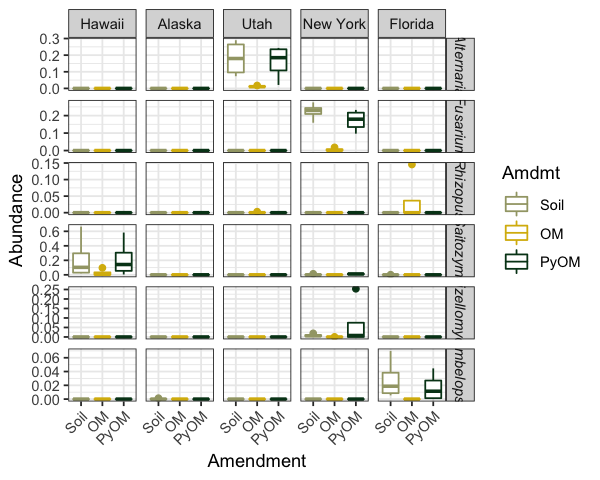

In [132]:
options(repr.plot.width=5, repr.plot.height=4)

p = ggplot(data=mdf, aes(x=Amdmt,y=Abundance,color=Amdmt))
p = p + geom_boxplot()
p = p + theme_bw()
p = p + theme(axis.text.x = element_text(angle=45,hjust=1))
palette = c(wes_palette("Cavalcanti1"))
palette = palette[c(3,1,2)]
p = p + scale_color_manual(values=palette)
p = p + facet_grid(~Genus~Soil_Trtmt, scales="free")
p = p + theme(strip.text.y = element_text(face="italic"))
p = p + xlab("Amendment")
p

In [136]:
ps.sig = prune_taxa(taxa_names(ps.norm) %in% SigOTUs,ps.norm)
mdf = psmelt(ps.sig)
mdf = mdf %>%
    filter(Day=="26")%>%
    filter(Amdmt=="Soil")%>%
    group_by(Soil_Trtmt,OTU)%>%
    summarize(meanAbund=mean(Abundance))%>%
    arrange(OTU)
mdf

Soil_Trtmt,OTU,meanAbund
Hawaii,OTU1,0.2233510377
Alaska,OTU1,0.0000000000
Utah,OTU1,0.0000000000
New York,OTU1,0.0035559854
Florida,OTU1,0.0004954054
Hawaii,OTU10,0.0000000000
Alaska,OTU10,0.0000000000
Utah,OTU10,0.0000000000
New York,OTU10,0.2234813037
Florida,OTU10,0.0000000000
